# The `.ml` extension

This notebook explores some of the popular examples from the machine learning extension of `turbopanda`.

In [1]:
import sys
import numpy as np
import pandas as pd
sys.path.insert(0,"../")
# our main import
import turbopanda as turb

import matplotlib.pyplot as plt
%matplotlib inline

print("turbopanda: %s" % turb.__version__)

turbopanda: 0.2.5


## Using *basic fit*: Fitting models using Linear Regression (OLS)

Given four key ingredients:

- `df`: A `MetaPanda` object
- `x`: A selector or list of columns in `df`
- `y`: A string selecting the target
- `model`: A string of which sklearn object to use, or alternatively the model itself

We fit this model to the data and return:

1. `cv`: the cross-validated repeat results of test scores, train scores, fit times etc, in addition to coefficients
for each parameter if available.
2. `yp`: the cross-validated predicted values for each element.

### Random cases

In [2]:
# random 1
df_1 = pd.DataFrame(np.random.normal(loc=2, scale=3, size=(100,3)), columns=['x1', 'x2', 'x3'])
df_1['y'] = np.random.normal(loc=0, scale=2, size=(100,))

# random 2
df_2 = pd.DataFrame(np.random.normal(loc=2, scale=3, size=(100,)), columns=['x1'])
df_2['y'] = np.random.normal(loc=0, scale=2, size=(100,))

#### Plotting the pairwise relationships

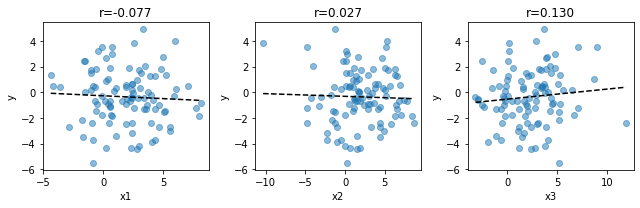

In [3]:
turb.plot.scatter_grid(turb.MetaPanda(df_1), 'x[1-3]', 'y')

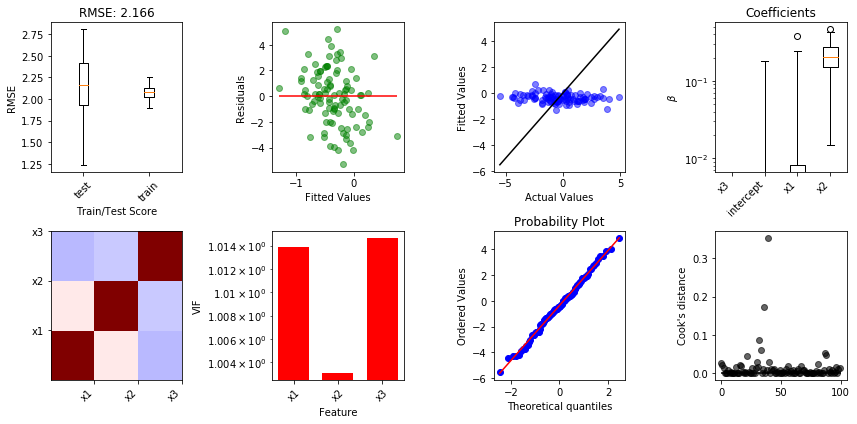

-2.169016830608247

In [4]:
cv, yp = turb.ml.fit.basic(turb.MetaPanda(df_1), 'x[1-3]', 'y', plot=True)
cv['test_score'].mean()

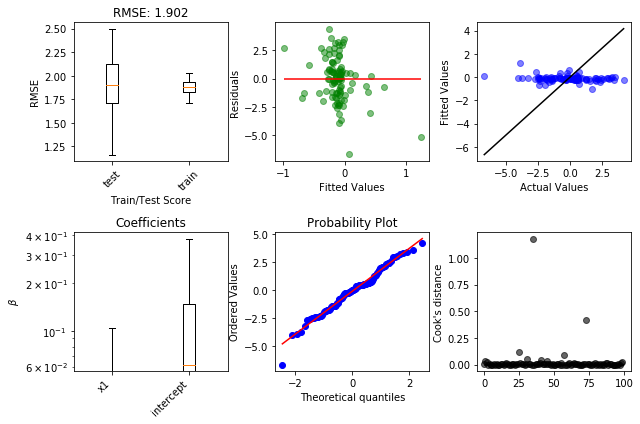

-1.916919505757424

In [5]:
cv, yp = turb.ml.fit.basic(turb.MetaPanda(df_2), 'x1', 'y', plot=True)
cv['test_score'].mean()

### Linear cases (with `plot=True`)

\begin{align}
y_i = \frac{1}{p} \left( \sum_j^p x_{ij} \right) + \epsilon_i
\end{align}

In [6]:
# linear 1
df_3 = pd.DataFrame(np.random.normal(loc=2, scale=3, size=(100,3)), columns=['x1', 'x2', 'x3'])
df_3['y'] = df_3.sum(axis=1) / 3. + np.random.normal(loc=0, scale=.25, size=(100,))

#### Plotting the relationship between each variable and $y$:

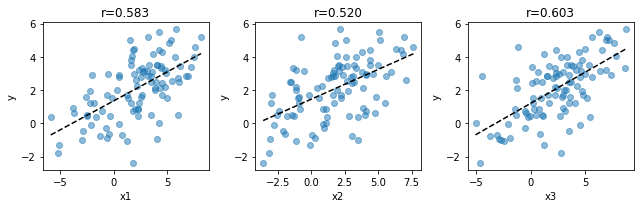

In [7]:
turb.plot.scatter_grid(turb.MetaPanda(df_3), "x[1-3]", "y")

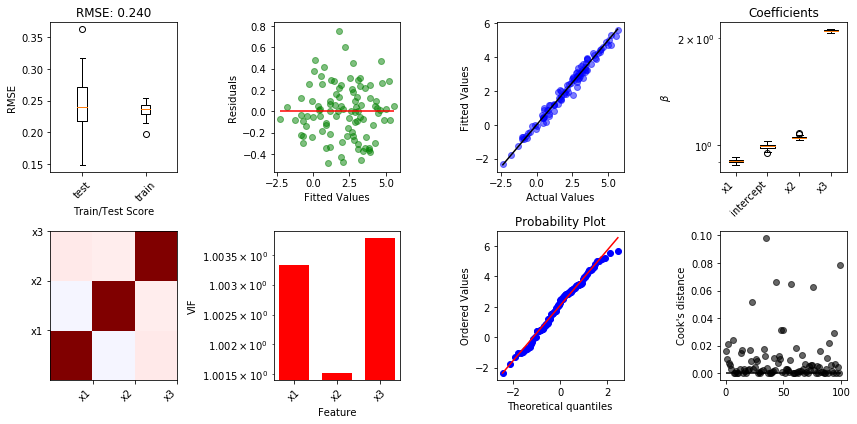

-0.24350681446711087


In [8]:
cv, yp = turb.ml.fit.basic(turb.MetaPanda(df_3), 'x[1-3]', 'y', 
                           model="LinearRegression", plot=True)
print(cv['test_score'].mean())

### Nonlinear case: $x^2$

\begin{align}
y_i = \left(\frac{1}{p} \sum_j^p x_{ij}^2 \right) + \epsilon_i \quad \forall i
\end{align}

We can also refer to model parameters by their 'short' name, i.e `model='lm'`.

In [9]:
X = np.random.normal(loc=2, scale=3, size=(100,3))
df_4 = pd.DataFrame(X, columns=['xc1', 'xc2', 'xc3'])

df_4['y'] = (df_4[['xc1', 'xc2', 'xc3']].sum(axis=1).div(3)**2) + np.random.normal(loc=0, scale=.25, size=(100,))

#### The relationship between variables...

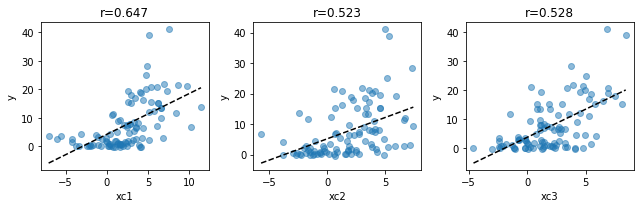

In [10]:
turb.plot.scatter_grid(turb.MetaPanda(df_4), "x", 'y')

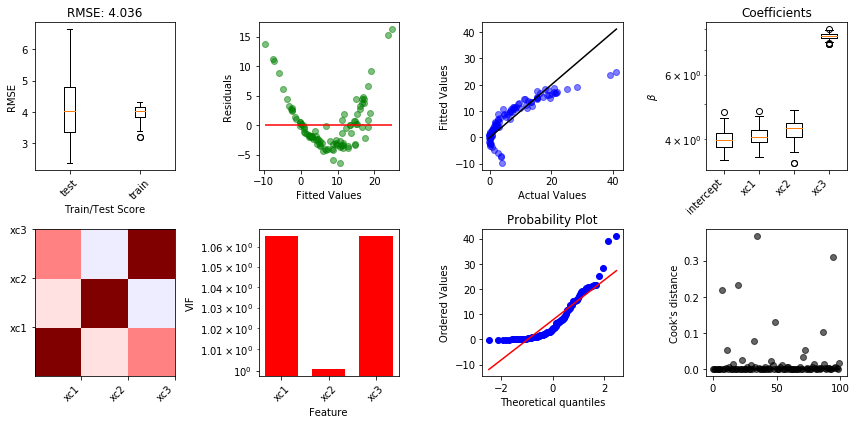

-4.137898211453981


In [11]:
cv, yp = turb.ml.fit.basic(turb.MetaPanda(df_4), 'x', 'y', 
                           model="lm", plot=True)
print(cv['test_score'].mean())


## Fitting a grid over the points

For example, we may wish to hyperparameterize $\alpha$ with a regularized linear regression model, such as Ridge or Lasso.

In the below example, by only specifying the models we wish to use, the **primary parameter** is the only one which is
iterated over using preset *default value ranges*.

For Lasso and Ridge, the primary parameter is always $\alpha$.

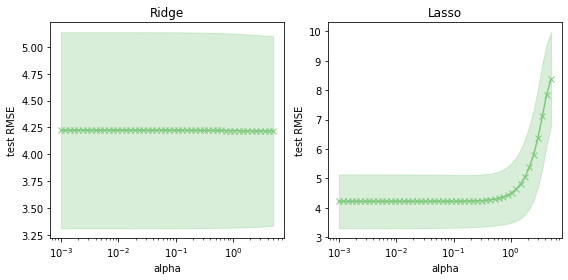

In [12]:
cv_r = turb.ml.fit.grid(turb.MetaPanda(df_4), "xc", "y", 
                        models=['Ridge', 'Lasso'], plot=True)

Below we instead specify the parameter we wish to iterate on, note here that we could specify more than one parameter.

Where there are two parameters, the secondary parameter is *split upon* into the legend, using colour.

For models which have no main parameters (i.e Ordinary Least Squares), a boxplot is displayed of the scoring value across $k$ and replicates.

In [13]:
cv_r = turb.ml.fit.grid(turb.MetaPanda(df_4), "xc", "y", 
                        models={
                            'lm': [],
                            'Ridge': ['alpha'], 
                            'DecisionTreeRegressor': ['max_depth', 'min_samples_split'],
                            'ElasticNet': ['alpha', 'l1_ratio']})

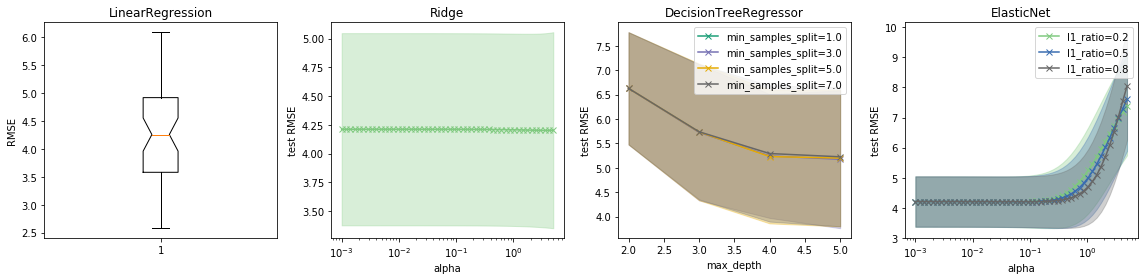

In [14]:
turb.ml.plot.parameter_tune(cv_r, arrange='column')

## Plotting which model did best...

We want to clearly see which model does the best from a large, complicated and infuriating `GridSearchCV` call:

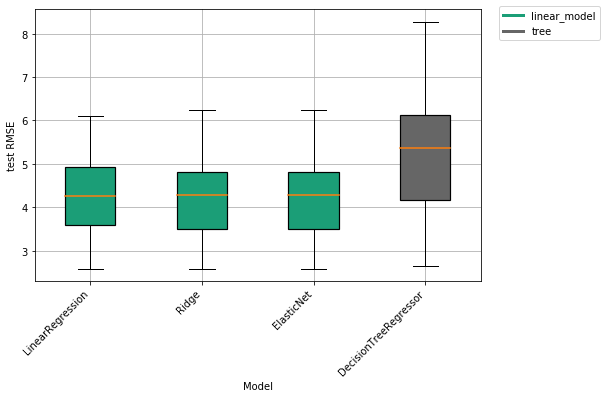

In [15]:
_ = turb.ml.plot.best_model(cv_r)

## Retrieving the best model..

Here we want to simply extract a copy of the `scikit-learn` model which performed best using a given GridSearch:

In [16]:
turb.ml.get_best_model(cv_r, minimize=False)

Ridge(alpha=3.5317636862616855, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

## Model validation via learning curves, permutations...

In addition to the basic and grid fitting options, we can also oscillate our model such that it can estimate the *uncertainty* of how good a particular model fit is:

1. The learning curve between $N$ training sizes and test score
2. The Scalability, measuring how long each fit takes with respect to $N$ train size
3. The Performance, measuring fit times against the test score.

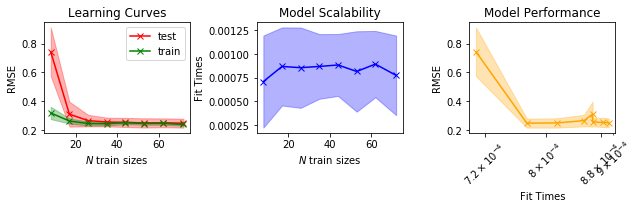

In [17]:
le_r = turb.ml.fit.learning(turb.MetaPanda(df_3), "x[1-3]", "y", 
                        model='Ridge', plot=True)

The `fit.learning` has a parameter named `permute_n` which by default is set to zero. If this value is $> 0$, then a fourth plot also appears with the permutations of y as a histogram to see the variance by removing y points and performing replicates.

Also we can specify the number of samples in $N$ train sizes we want the model to take using the `train_n` parameter.

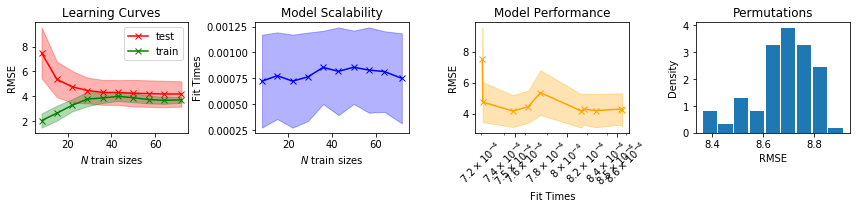

In [18]:
le_r = turb.ml.fit.learning(turb.MetaPanda(df_4), "xc", "y", 
                            train_n=np.linspace(.1, .9, 10),
                        model='Ridge', permute_n=100, plot=True)